<a href="https://colab.research.google.com/github/nudojacopo/thesis/blob/main/HWK_labs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes for Jacopo:


 <br>


Define the module path + import packages

In [17]:
kernel=input('Choose a kernel to use...are you running in local? Y/N')

Choose a kernel to use...are you running in local? Y/Nn


In [18]:
if kernel!='Y':
  !git clone https://github.com/nudojacopo/thesis.git
  from google.colab import drive
  drive.mount('/content/drive')
  source_data='/content/drive/MyDrive/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/content/'
else:
  source_data='/Users/jacoponudo/Documents/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/Users/jacoponudo/Documents/'
output=root+'src/HWK/output'
output_threads=root+'src/HWK/output/temporary'
import sys
module_path = root+'thesis/src/HWK'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from HWK_package.functions import *
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

fatal: destination path 'thesis' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set source

In [22]:
dataset = pd.read_parquet(source_data)

In [23]:
dataset['is_toxic']=dataset['toxicity_score']>0.6
user_toxic_activity=dataset.groupby(['root_submission','user'])['is_toxic'].sum().reset_index()
user_toxic_activity[user_toxic_activity['is_toxic']>10]

,root_submission,user,is_toxic
25640,1073880,smokratez,11
28075,1080682,diesel4420,14
29955,1085786,EarlPoncho,18
32689,1093318,Crensch,11
34120,1097033,Crensch,23
...,...,...,...
2494625,767799,twentyfive,12
2531879,867711,escapefromredditbay,14
2554660,923752,twentyfive,11
2558049,933237,Dead-_,12


In [24]:
dataset_user=dataset[dataset.user=='Mumbleberry'].copy()
dataset_user.sort_values(by='created_at', inplace=True)
dataset_user.root_submission.value_counts()
dataset_user=dataset_user[dataset_user.root_submission=='3348062'].copy()

Q1: Could we use a hawkes process to model the inter arrival time of comments?

Preparo i dati e fitto il modello

In [25]:
observed_data = np.array([np.datetime64(x.replace(tzinfo=None)).astype(np.int64) for x in dataset_user['created_at']])
mean_lag=np.mean(np.diff(observed_data))
ℋ_t=observed_data-min(observed_data)+mean_lag
𝛉_exp=𝛉_exp_simple=exp_mle(ℋ_t,max(ℋ_t)+mean_lag)

Faccio il QQplot del modello

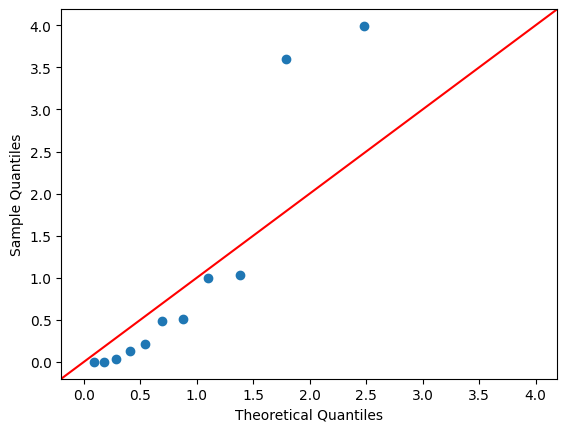

In [26]:
tsShifted = exp_hawkes_compensators(ℋ_t, 𝛉_exp)
iat = np.diff(np.insert(tsShifted, 0, 0))
qqplot(iat, dist=stats.expon, fit=True, line="45")
plt.show()

Estraggo una metric per valutare il modello

In [27]:
slope, intercept = sm.OLS(iat, sm.add_constant(stats.expon.ppf((np.arange(1, len(iat) + 1) - 0.5) / len(iat)))).fit().params
print("Pendenza della linea di riferimento adattata:", slope)
slope, intercept = 1, 0
predicted_values = slope * np.arange(1, len(iat) + 1) + intercept

Pendenza della linea di riferimento adattata: 1.2506055664892735


Calcolo delle distanze

In [28]:
distances = np.abs(iat - predicted_values)

In [29]:
print('errore modello semplice',distances.mean())

errore modello semplice 5.103887079873856


Q2: Is the fitting of the model improving using a flexibility of alpha (infetivity rate) sensible to comment's toxicity?

In [30]:

# Preparo i dati e fitto il modello
observed_data = np.array([np.datetime64(x.replace(tzinfo=None)).astype(np.int64) for x in dataset_user['created_at']])
mean_lag=np.mean(np.diff(observed_data))
ℋ_t=observed_data-min(observed_data)+mean_lag
𝒯_T=list(dataset_user.toxicity_score)
𝛉_exp=𝛉_exp_toxicity=exp_mle_toxicity(ℋ_t,𝒯_T,max(ℋ_t))

Faccio il QQplot del modello

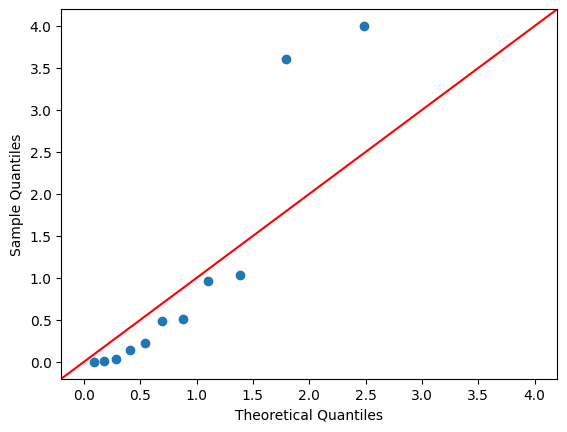

In [31]:
tsShifted = exp_hawkes_compensators_toxicity(ℋ_t,𝒯_T, 𝛉_exp)
iat = np.diff(np.insert(tsShifted, 0, 0))
qqplot(iat, dist=stats.expon, fit=True, line="45")
plt.show()

Estraggo una metric per valutare il modello

In [32]:
slope, intercept = sm.OLS(iat, sm.add_constant(stats.expon.ppf((np.arange(1, len(iat) + 1) - 0.5) / len(iat)))).fit().params
print("Pendenza della linea di riferimento adattata:", slope)

Pendenza della linea di riferimento adattata: 1.384439183937668


In [33]:
slope, intercept = 1, 0
predicted_values = slope * np.arange(1, len(iat) + 1) + intercept

Calcolo delle distanze

In [34]:
distances = np.abs(iat - predicted_values)

In [35]:
print('errore modello tossicità',distances.mean())

errore modello tossicità 4.9998597136193155


Q3 Posso stimare i parametri di ciascun utente studiandone la verosimiglianza congiunta su tutti i threads?<br>
--------------------------- Using α ---------------------------------------------------

In [36]:
data_user = filter_dataset(dataset, 'Mumbleberry', min_comments=3, sample=False)
ℋ_T_list, magnitude_list,time_list = prepare_data(data_user, dataset)
θ_exp_mle_T = exponential_mle(ℋ_T_list, time_list)

/content/thesis/src/HWK/HWK_package/functions.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='created_at', inplace=True)


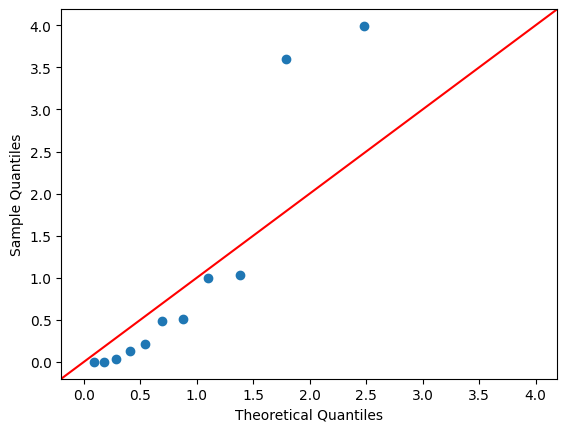

In [37]:
tsShifted = exp_hawkes_compensators(ℋ_t, θ_exp_mle_T)
iat = np.diff(np.insert(tsShifted, 0, 0))
qqplot(iat, dist=stats.expon, fit=True, line="45")
plt.show()

In [38]:
slope, intercept = sm.OLS(iat, sm.add_constant(stats.expon.ppf((np.arange(1, len(iat) + 1) - 0.5) / len(iat)))).fit().params
print("Pendenza della linea di riferimento adattata:", slope)

Pendenza della linea di riferimento adattata: 0.037238471722014464


In [39]:
slope, intercept = 1, 0
predicted_values = slope * np.arange(1, len(iat) + 1) + intercept

In [40]:
distances = np.abs(iat - predicted_values)
print('errore modello tossicità',distances.mean())

errore modello tossicità 5.973319434241515


--------------------------- Using 2α ---------------------------------------------------

In [41]:
data_user = filter_dataset(dataset, 'Mumbleberry', min_comments=3, sample=False)
ℋ_T_list, magnitude_list,time_list = prepare_data(data_user, dataset)
θ_exp_mle_T = exponential_mle_toxicity(ℋ_T_list, magnitude_list, time_list)

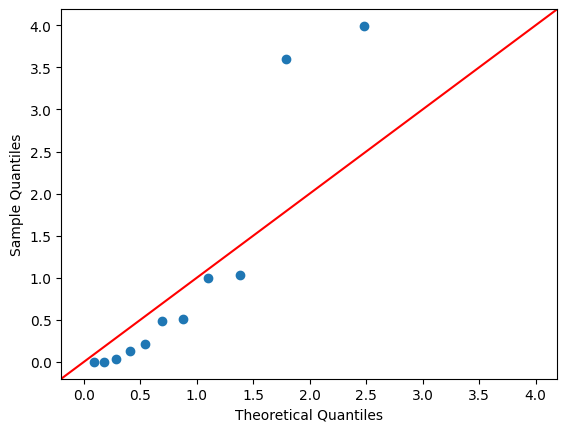

In [42]:
tsShifted = exp_hawkes_compensators_toxicity(ℋ_t,𝒯_T, θ_exp_mle_T)
iat = np.diff(np.insert(tsShifted, 0, 0))
qqplot(iat, dist=stats.expon, fit=True, line="45")
plt.show()

In [43]:
slope, intercept = sm.OLS(iat, sm.add_constant(stats.expon.ppf((np.arange(1, len(iat) + 1) - 0.5) / len(iat)))).fit().params
print("Pendenza della linea di riferimento adattata:", slope)

Pendenza della linea di riferimento adattata: 0.037238471722014464


In [44]:
slope, intercept = 1, 0
predicted_values = slope * np.arange(1, len(iat) + 1) + intercept

In [45]:
distances = np.abs(iat - predicted_values)
print('errore modello tossicità',distances.mean())

errore modello tossicità 5.973319434241515
